In [1]:
# In this notebook we will understand the activations and gradients during training and back-propagation (specially gradients when they flowing backwards, how they behave and
# and how they look like). 

## And to understand the history why did they developed advanced architectures like RNN, LSTM and More. 
## This advanced models "RNN", "LSTM", and "GRU" are vey touch to optimize, to understand why this notebook will be very useful. 

## Let's create a dataset and model and complete the training before understanding this:) 

In [2]:
# imports 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


C:\Users\aravi\AppData\Local\Temp\ipykernel_28424\550266794.py:15: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  X = torch.tensor(X)


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [22]:
# same optimization as last time
max_steps = 40000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  break
  

      0/  40000: 3.4957


In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.587782382965088
val 2.6106646060943604


## Fixing initial Loss 

In [14]:
## Now we completed this training and let's debug the issues:) 

## The first thing we are going to understand the weight initialization. 
## if you see the loss for first step it's very high, it's states that weight initialization is too high or very bad:) 

""" 
In training of neural nets its almost always the case that you will have a rough idea for what loss to expect at initialization. It's depends on the problem setup and loss function. 
we can calculate using the possible outcomes: 

For Example: If you  have 27 possible outcomes, we can expect that that the possibility of next character is 27. 
at initialization, we have no reason to believe any characters to be much more likely than others. We would expect the probabilities distribution that comes out initially is 
a uniform distribution assigning equal probability to all 27 characters.  

So the probability of any character is 1/27.0 and then calculate the loss. 

"""
inLoss = - torch.tensor(1/27.0).log()
print(f"Initial loss assumption: {inLoss}")  # 3.29 

""" 
In our case we got more loss (25+). This means, In neural net while initialization the weights are messed up. Some characters are very confident and some characters are not confident. 

To solve this: we want the logits to roughly zero when the network is  initialized. Let's see the logits for initial step. Please add break statement in the training loop and
execute this bellow code :) 
We can also solve by making the weights uniform. Will see this :) 
"""

print(f"Initial Logits: {logits[0]}\nVery high we need roughly zero 😍")  # This are all very high values we need to be roughly zero 


Initial loss assumption: 3.295836925506592
Initial Logits: tensor([ 3.7627e+00,  6.3170e+00, -5.6324e-01, -6.4921e-01,  3.8004e-04,
         4.8292e+00, -5.2193e+00, -7.8016e-01,  1.8332e+00,  3.0436e+00,
        -1.9714e+00, -2.2416e+00,  2.5453e+00, -8.1987e-01, -1.3570e+00,
         2.9829e+00, -2.5108e+00, -3.8701e+00,  1.4292e+00,  3.0940e-01,
         3.0391e-01,  3.4396e-01, -2.8735e-01, -1.8788e+00, -3.9309e+00,
         3.1855e+00,  9.7701e-01], grad_fn=<SelectBackward0>)
Very high we need roughly zero 😍


In [15]:
# Let's make some changes in the initialization process :) 

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 

## Logits are calculated by h@W2+b2. We are initializing the b2 with random values(gaussian) of right size.Here we want roughly zeros we don't want random numbers. So let's add zero 
## it means b2 is zero while initialization.   
b2 = torch.randn(vocab_size,                      generator=g) * 0  

## Second we get logits by h@W2. So, we want logits to be very small, for this we would multiply the small value with W2 to get the small logits. 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 
## why we need small logits(logits near to zero) will discuss later!! 

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True
  
# Now run the training loop and see the initial loss. Note! Don't forget to add break statement to get the first step logits. 
## If you see the loss we are getting roughly 3.5+ it's very great compare to previous initialization which is 27+ loss. 
## Now remove the break statement, run the full training and see the training loss. You will get amazing result because of this initialization. It got around 1.64 loss(cool 😍)

11897


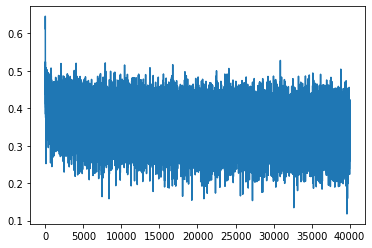

In [16]:
plt.plot(lossi); 

## why the plot is not like hockey stick (as usual) because most of the time the weight initialization at first is very bad so we usually get very high value. 
## And our model need to optimize the very big loss to low loss, this is the reason we usually get the hockey stick graph. 
## But now we got a thin straight graph because our initialization is perfect. This is fine :) 

## We got a very good results because instead of spending first 1000 iterations to reduce the loss or squashing down the weights. This is very useful technique :) 

## Fixing Tanh Backward gradient issue.

In [17]:
# Tanh converts all the values between -1 to +1 very smoothly. When back-propagating to the tanh, we will end with zero gradient error and it makes the neuron to zero. 
# To understand this we need to understand the back-propagation calculation for the tanh function. 

def tanh_back_propagation(forward_output_of_tanh, previous_gradients): 
    """Tanh back-propagation function"""
    grad += (1 - forward_output_of_tanh**2) * previous_gradients
    
    return grad
    
## The problem !! 
# Consider forward_tanh_output = 1(feed forward), when back propagating we will insert this (1) in the formula, then gradients gets 0. because (1 - output**2) becomes 0. 
# Consider forward_tanh_output = -1(feed forward), when back propagating we will insert this (-1) in the formula, then gradients gets 0. because (1 - (-1)**2) becomes 0. 
# We know the tanh compress the inputs to -1 to +1 smoothly, but back propagating makes it zero. It means it destroy gradients to be zero. 
# This makes the neuron to be zero (dead neuron). This neuron will never learn anything after this.
# This dead neuron sometimes happen in the initialization by chance or most of the time it happens while optimize the neural networks.
      
## The problem with some other activation functions !! 
# This is not only for tanh, other activation functions also has this issues like "sigmoid", "relu" and some more (research about this)
 
## Will see how to solve this problem before this let's understand visually bellow :0  

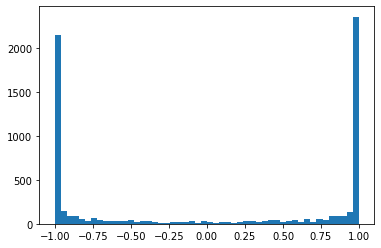

In [52]:
## Let's see the output of tanh in histogram 
plt.hist(h.view(-1).tolist(), 50); # view(-1) make to single dimension tensor 

## If you see the diagram, most of the value are in -1 and +1, it means most of outputs are near to -1 and +1 and this makes backward gradients makes destroy while back-propagating.  

In [73]:
# How to solve this problem ? 
## If you see the network "h" is calculated by "emb@W1+b1" this is "hpreact". So let's optimize "b1" and "W1" to solve this issue. Why? 
## Because, This calculation "emb@W1+b2" makes the values to far from zero because of this our tanh is squashing between -1 to +1. We want "hpreact" closer to zero. 
## Let's solve this. So, let's add small values to W1 and b2 while initialization. 

In [21]:
# Let's add some small value to W1 and b1 to solve this issue: 

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# hpreact(emb@W1+b) Let's add some small values to W1 and b1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0  
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 


parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True
  
# Now put a break statement in the training loop and visualize the h(tanh) histogram to see if it's contains more -1 or +1. 

11897


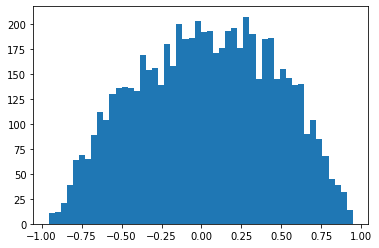

In [23]:
plt.hist(h.view(-1).tolist(), 50);

# Now we have very less -1 and +1. In-fact we don't have. It helps to avoid the dead neuron. 
# And it makes the distribution very cooler ;) 

In [28]:
# plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")  # If you see white color in the picture, it means it has value near 1. 
# If the plot has more white it means we have lot of values near to 1, which makes more dead neuron in our network. 

In [29]:
# Let's see all the result after optimization of our network ;) 

## Original network without optimization: 
# train 2.12
# val 2.16 

## fix tanh backward issue 
# train 2.07 
# val 2.13 

## fix initialization issue 
# train 2.03 
# val 2.10

## Kaiming Init 

In [30]:
# Here we have very less network. So, we optimized the network very easily. But in practice we usually have very big networks in that case we will end up with lot of problems to optimize. 
# In practice, no one initializes the weight like what we did. What if we have 1000 of networks, and how do we initialize the weight?
# To initialize the weight for larger networks, people usually follows some techniques like Kaiming Init (please look pytorch documentation to understand this)

""" 
Before this we need to lookup something: 
-> Now-a-days you don't need to worry about the weight initialization because of modern architectures. 
-> In modern architectures people uses "batch_normalization", "layer_normalization" and more techniques which significantly helps to reduce the loss and training time of the model.
-> First we will learn about batch normalization !! 

"""

## Batch Normalization

In [1]:
"""
# It came about 2015 by the google team! 
# It made it to train the very deep neural net quite reliably. 
# Let's understand how it's giving benefits. 
## We don't need a pre-activation should be very large so tanh makes to 1, or very small so tanh makes to -1. 
## In-fact we need pre-activation  roughly gaussian. (0mean and 1std-deviation) at-least at initialization. 
## This is what Batch normalization doing, it takes the "pre-activation" and normalizes it to "gaussian distribution:" 
## 
"""

'\n# It came about 2015 by the google team! \n# It made it to train the very deep neural net quite reliably. \n# Let\'s understand how it\'s giving benefits. \n## We don\'t need a pre-activation should be very large so tanh makes to 1, or very small so tanh makes to -1. \n## In-fact we need pre-activation  roughly gaussian. (0mean and 1std-deviation) at-least at initialization. \n## This is what Batch normalization doing, it takes the "pre-activation" and normalizes it to "gaussian distribution:" \n## \n'

In [1]:
# Let's see in action!!

import torch 

## Consider this is a pre-activation with the shape of 32, 200. 
hpreact = torch.randn( (4, 2, 2) ) # This is pre-activation (we need this roughly gaussian)

## Let's take this and normalize to gaussian distribution.  



In [27]:
fourth = torch.randn( (4, 3, 2) )
# torch.
fourth.shape




torch.Size([4, 3, 2])

In [28]:
import torchshow as ts

In [29]:
len(fourth)

4

In [30]:
fourth[0]

tensor([[ 0.9798, -0.3100],
        [ 0.6040,  0.9283],
        [ 0.3635,  1.5184]])

In [ ]:
ts.show(fourth)

In [317]:
# hpreact.mean(dim = 0)

In [318]:
hpreact

tensor([[[-0.0556,  0.3648],
         [ 0.4200,  1.2959]],

        [[-0.8864, -1.4869],
         [ 0.0200,  0.0561]],

        [[ 0.7532,  1.4177],
         [ 1.9945,  0.3951]],

        [[-0.8401, -2.0891],
         [ 0.2592, -0.5302]]])

In [310]:
# dim = 0 

hp_a = ( (0.0152 + 0.5926 + 0.6839 + 0.0231)/ 4)
hp_b = ( (0.9670 + 0.5716 + -0.0575 + 1.0428)/ 4)


hp_c = ( (0.7838 + 0.2630)/ 2)
hp_d = ( (-0.0374 + 0.7228)/ 2 )

(hp_a, hp_b)


(0.3287, 0.630975)

In [322]:
# dim = 1 

hp_a_ = ( (-0.0556 + 0.4200)/ 2)
hp_b_ = ( (0.3648 + 1.2959)/ 2)

hp_c_ = ((-0.8864 + 0.0200)/ 2) 
hp_d_ = ((-1.4869 + 0.0561)/ 2) 

( hp_c_, hp_d_)

(-0.4332, -0.7154)

In [321]:
hpreact.mean(dim = 1)

tensor([[ 0.1822,  0.8303],
        [-0.4332, -0.7154],
        [ 1.3739,  0.9064],
        [-0.2904, -1.3097]])

In [144]:
for i in range(4): 
    # print(a[:,i].sum() / len(a[:,i]))
    print(a[i, :].sum()/ len(a[i, :]))

tensor(-0.3894)
tensor(-0.1993)
tensor(-0.5139)
tensor(-0.4111)


In [255]:
a = [
 [[ 1.,  2.,  3.,  4.],
  [ 5.,  6.,  7.,  8.],
  [ 9., 10., 11., 12.]],
 [[13., 14., 15., 16.],
  [17., 18., 19., 20.],
  [21., 22., 23., 24.]], 
 ]

a = torch.tensor(a) 



In [243]:
# dim = 0 for batches 
a_ = ( (1 + 13 + 25) / 3)
b = ( (2+14 + 26) / 3 )
c= ( (3+15+27) / 3 ) 
d= ( (4+16+28) / 3 ) 

print(a_, b, c, d)

13.0 14.0 15.0 16.0


In [259]:
b = torch.tensor([
                   [1., 2., 3., 4.], 
                   [5., 6., 7., 8.], 
                   [9., 10., 11., 12.]
                   ], 
                   )

b.mean(dim=0)

tensor([5., 6., 7., 8.])

In [272]:
b.mean()

tensor(6.5000)

In [263]:
# dim = 1 for non-batch 
ba__ = ( (1 + 2 + 3 + 4)/ 4) 
bb__ = ( (5 + 6 + 7 + 8)/ 4)
bc__ = ( (9 + 10 + 11 + 12)/ 4)

(ba__, bb__, bc__) 

(2.5, 6.5, 10.5)

In [207]:
# Since operations components are written in C++, they are not callable with operations such as ?? or "__file__" or "getsourcefile" type of operations.

tensor(5.)

In [208]:
a[1][:, 0].sum() / 3

tensor(17.)